<a href="https://colab.research.google.com/github/nagasora/MITSUI-CO.-Commodity-Prediction-Metric/blob/main/EDA%E3%80%81%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
f = open("/content/drive/MyDrive/kaggle notebook/kaggle.json")
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']


In [ ]:
!pip install kaggle


In [ ]:
#APIコマンドを入力
!kaggle competitions download -c mitsui-commodity-prediction-challenge

  0% 0.00/9.94M [00:00<?, ?B/s]
100% 9.94M/9.94M [00:00<00:00, 706MB/s]


In [ ]:
import os
import zipfile

# Specify the path to the zip file in Google Drive
zip_file_path = "/content/mitsui-commodity-prediction-challenge.zip"

# Specify the destination directory (same as the zip file directory)
destination_directory = os.path.dirname(zip_file_path)

# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_directory)

print(f"File unzipped to: {destination_directory}")

File unzipped to: /content


#data loading and first exploration


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette('husl')

train = pd.read_csv('/content/train.csv')
train_labels = pd.read_csv('/content/train_labels.csv')
target_pairs = pd.read_csv('/content/target_pairs.csv')

print('training data:', train.shape)
print('train label:', train_labels.shape)
print('target_pairs:', target_pairs.shape)

training data: (1917, 558)
train label: (1917, 425)
target_pairs: (424, 3)


# feature categories anlysis


In [ ]:
def categorize_columns(columns):
  categories = {
      'LME': [col for col in columns if col.startswith('LME_')],
      'JPX': [col for col in columns if col.startswith('JPX_')],
      'US': [col for col in columns if col.startswith('US_Stock_')],
      'FX': [col for col in columns if col.startswith('FX_')],
      'Other': [col for col in columns if not any(col.startswith(prefix) for prefix in ['LME_', 'JPX_', 'US_Stock_', 'FX_'])]
  }
  return categories

feature_categories = categorize_columns(train.columns)

for category, columns in feature_categories.items():
  print(f"{category}: {len(columns)} columns")
  if len(columns) <= 10:
    print(f" columns: {columns}")

  else:
    print(f"  Sample: {columns[:5]} ... {columns[-2:]}")
  print()

LME: 4 columns
 columns: ['LME_AH_Close', 'LME_CA_Close', 'LME_PB_Close', 'LME_ZS_Close']

JPX: 40 columns
  Sample: ['JPX_Gold_Mini_Futures_Open', 'JPX_Gold_Rolling-Spot_Futures_Open', 'JPX_Gold_Standard_Futures_Open', 'JPX_Platinum_Mini_Futures_Open', 'JPX_Platinum_Standard_Futures_Open'] ... ['JPX_Platinum_Standard_Futures_open_interest', 'JPX_RSS3_Rubber_Futures_open_interest']

US: 475 columns
  Sample: ['US_Stock_ACWI_adj_open', 'US_Stock_AEM_adj_open', 'US_Stock_AG_adj_open', 'US_Stock_AGG_adj_open', 'US_Stock_ALB_adj_open'] ... ['US_Stock_XOM_adj_volume', 'US_Stock_YINN_adj_volume']

FX: 38 columns
  Sample: ['FX_AUDJPY', 'FX_AUDUSD', 'FX_CADJPY', 'FX_CHFJPY', 'FX_EURAUD'] ... ['FX_NOKJPY', 'FX_ZARGBP']

Other: 1 columns
 columns: ['date_id']



# missing values anlysis

missing values analysis:
LME
columns: 4
average missing %: 2.61%
  Range: 2.61% - 2.61%

JPX
columns: 40
average missing %: 6.00%
  Range: 6.00% - 6.00%

US
columns: 475
average missing %: 4.22%
  Range: 3.34% - 87.06%

FX
columns: 38
average missing %: 0.00%
  Range: 0.00% - 0.00%

Other
columns: 1
average missing %: 0.00%
  Range: 0.00% - 0.00%



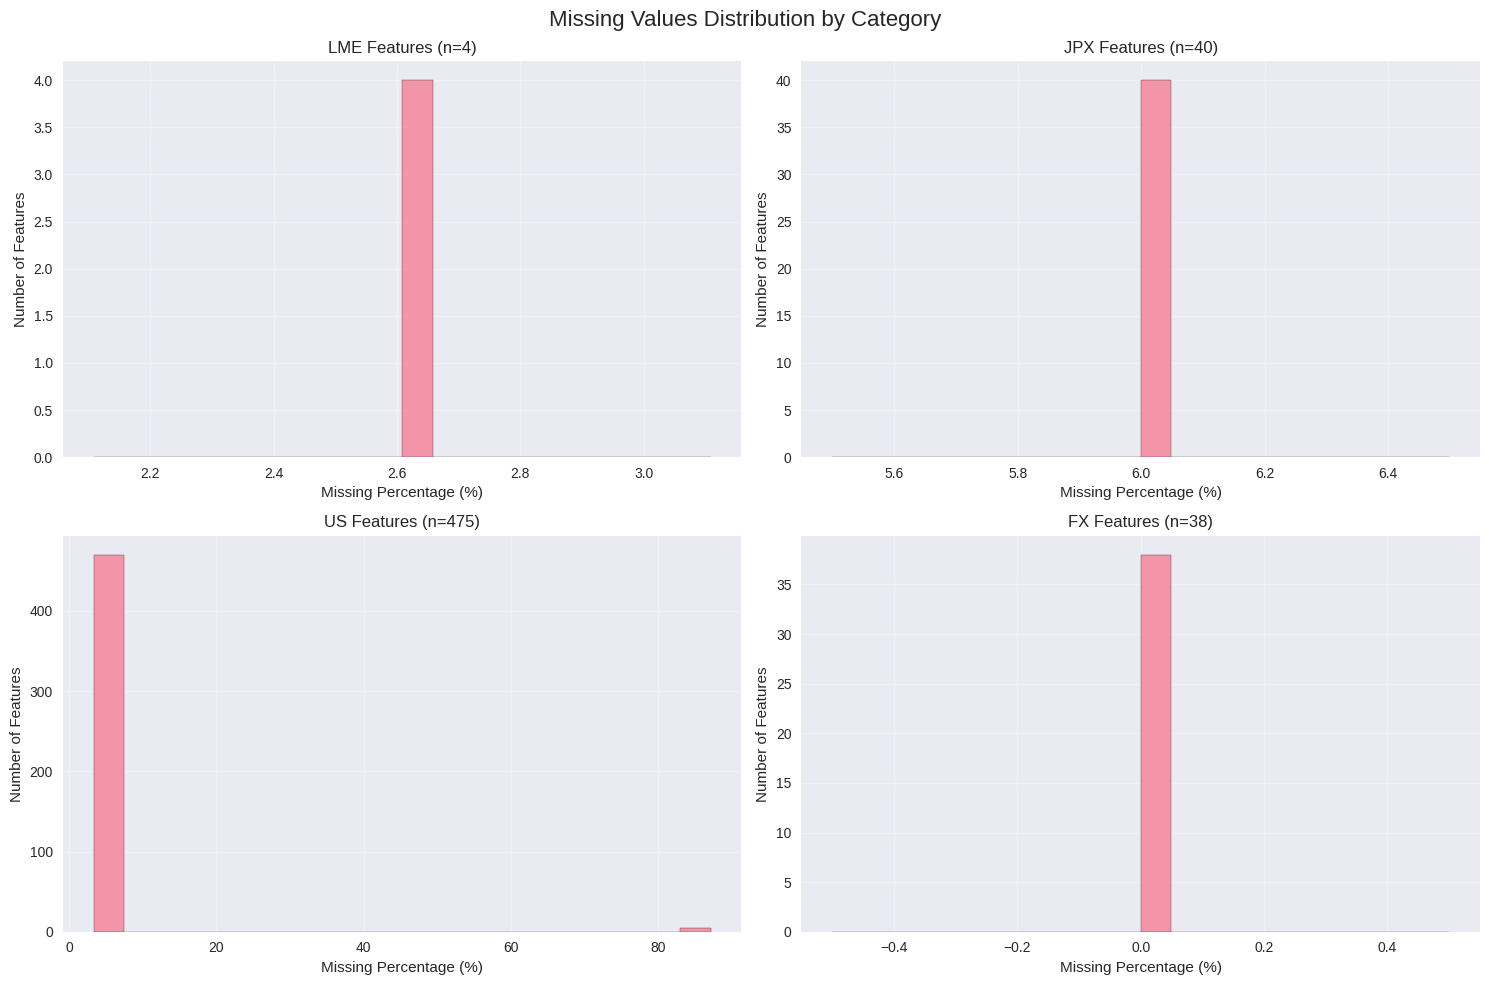

In [ ]:
def missing_values_analysis(df, categories):
  missing_stats = {}

  for category, columns in categories.items():
    if not categories:
      continue

    category_missing = df[columns].isnull().sum()
    missing_pct = (category_missing / len(df)* 100 ).round(2)
    missing_stats[category] = {
        'columns:' : len(columns),
        'total_missing': category_missing.sum(),
        'avg_missing_pct': missing_pct.mean(),
        'max_missing_pct': missing_pct.max(),
        'min_missing_pct': missing_pct.min()
    }

  return missing_stats

missing_analysis = missing_values_analysis(train, feature_categories)
print('missing values analysis:')
for category, stats in missing_analysis.items():
  print(f"{category}")
  print(f"columns: {stats['columns:']}")
  print(f"average missing %: {stats['avg_missing_pct']:.2f}%")
  print(f"  Range: {stats['min_missing_pct']:.2f}% - {stats['max_missing_pct']:.2f}%")
  print()

#visualizing missing values
fig, axes = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Missing Values Distribution by Category', fontsize=16)

categories_to_plot = ['LME', 'JPX', 'US', 'FX']
for idx, category in enumerate(categories_to_plot):
    ax = axes[idx // 2, idx % 2]

    if feature_categories[category]:
        missing_pct = train[feature_categories[category]].isnull().sum() / len(train) * 100
        ax.hist(missing_pct, bins=20, alpha=0.7, edgecolor='black')
        ax.set_title(f'{category} Features (n={len(feature_categories[category])})')
        ax.set_xlabel('Missing Percentage (%)')
        ax.set_ylabel('Number of Features')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# target variable analysis


targets on periods
 Lag 1: 106 targets
 Lag 2: 106 targets
 Lag 3: 106 targets
 Lag 4: 106 targets

Total Targets: 424
target_types
Single target instruments: {4}
Pair target instruments: {420}


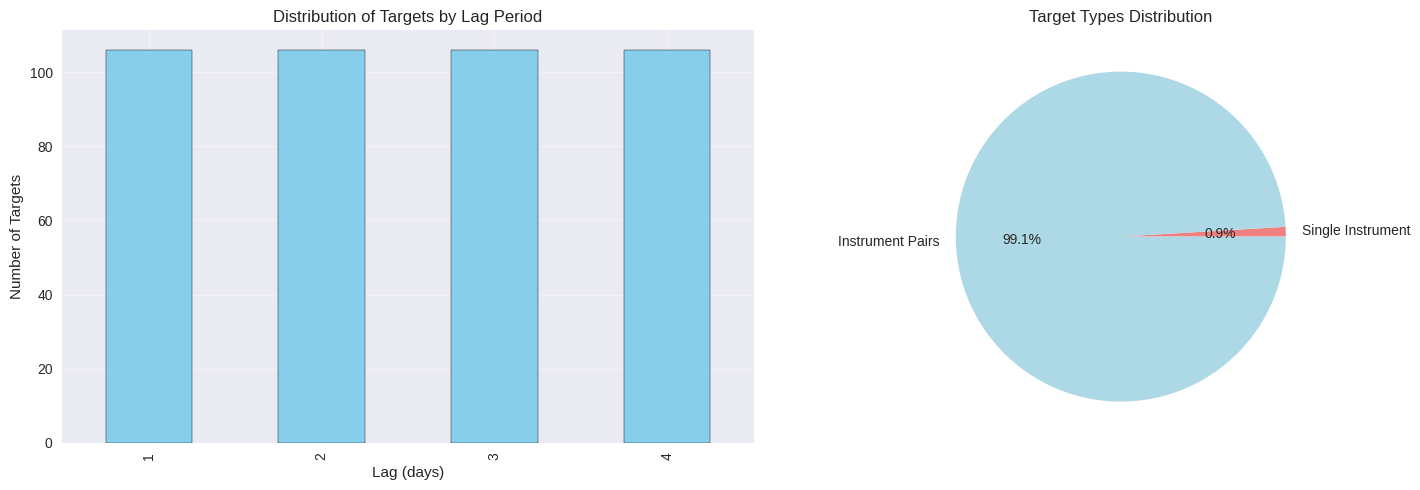

In [ ]:
#count by lag
lag_counts = target_pairs['lag'].value_counts().sort_index()
print('targets on periods')
for lag, count in lag_counts.items():
  print(f" Lag {lag}: {count} targets")

print(f"\nTotal Targets: {len(target_pairs)}")

def categorize_targets(target_pairs):
  single_targets = []
  pair_targets = []

  for _, row in target_pairs.iterrows():
    pair = row['pair']
    if '-' in pair:
      pair_targets.append(row)
    else:
      single_targets.append(row)

  return single_targets, pair_targets

single_targets, pair_targets = categorize_targets(target_pairs)

print(f"target_types")
print(f"Single target instruments:", {len(single_targets)})
print(f"Pair target instruments:", {len(pair_targets)})

# Visualize target types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Lag distribution
lag_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Targets by Lag Period')
ax1.set_xlabel('Lag (days)')
ax1.set_ylabel('Number of Targets')
ax1.grid(True, alpha=0.3)

# Target types
target_types = ['Single Instrument', 'Instrument Pairs']
type_counts = [len(single_targets), len(pair_targets)]
ax2.pie(type_counts, labels=target_types, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
ax2.set_title('Target Types Distribution')

plt.tight_layout()
plt.show()






# target values distribution analysis

Target values statistics
<bound method NDFrame.describe of       target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0     0.005948 -0.002851 -0.004675 -0.000639       NaN       NaN -0.006729   
1     0.005783 -0.024118 -0.007052 -0.018955 -0.031852 -0.019452  0.003002   
2     0.001048  0.023836 -0.008934 -0.022060       NaN       NaN  0.037449   
3     0.001700 -0.024618  0.011943  0.004778       NaN       NaN -0.012519   
4    -0.003272  0.005234  0.006856  0.013312  0.023953  0.010681 -0.011649   
...        ...       ...       ...       ...       ...       ...       ...   
1912 -0.012596  0.009309  0.007947  0.006477 -0.026216 -0.029487 -0.003287   
1913 -0.000736 -0.001292 -0.005137 -0.007961 -0.008494 -0.011547  0.004263   
1914 -0.002294  0.012898  0.009978  0.001567  0.002596 -0.007373  0.007554   
1915       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1916       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

    

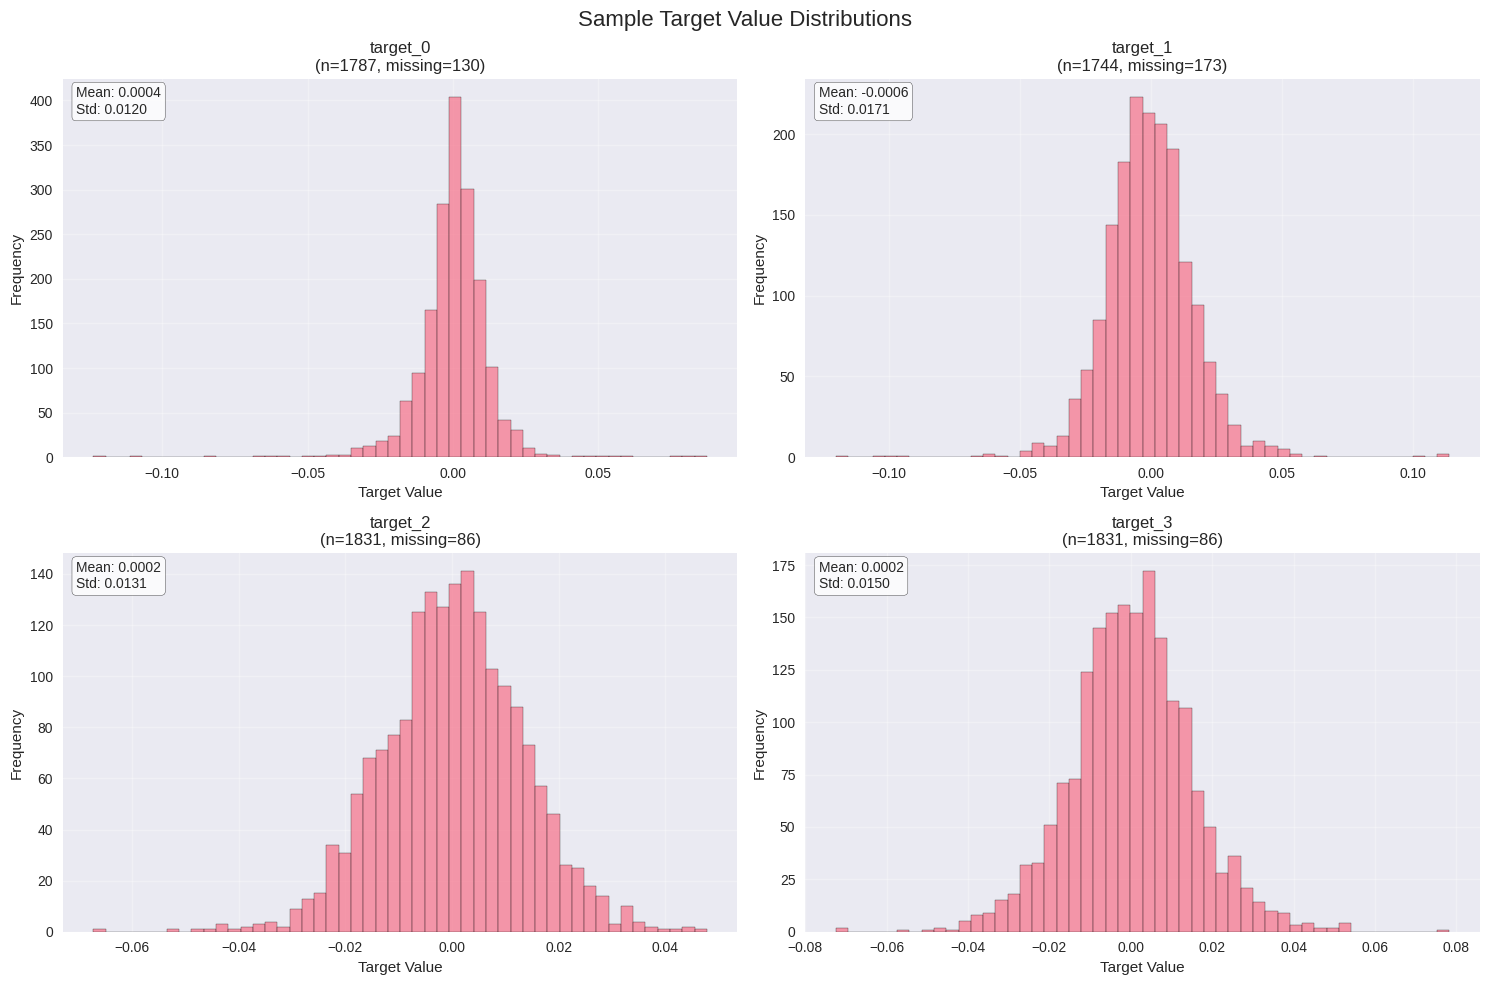

In [ ]:
target_columns = [col for col in train_labels.columns if col.startswith('target')]

print('Target values statistics')

target_stats = train_labels[target_columns].describe
print(target_stats)

target_missing = train_labels[target_columns].isnull().sum()
print('missing values in target columns')
print(f"total missing: {target_missing.sum()}")
print(f'target with missing values: {(target_missing > 0).sum()}')
print(f"average missing per targets: {target_missing.mean():.2f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sample_targets = target_columns[:4]
for idx, target in enumerate(sample_targets):
  ax = axes[idx // 2, idx % 2]
# Remove null values for plotting
  target_values = train_labels[target].dropna()

  ax.hist(target_values, bins=50, alpha=0.7, edgecolor='black')
  ax.set_title(f'{target}\n(n={len(target_values)}, missing={train_labels[target].isnull().sum()})')
  ax.set_xlabel('Target Value')
  ax.set_ylabel('Frequency')
  ax.grid(True, alpha=0.3)

  # Add statistics text
  stats_text = f'Mean: {target_values.mean():.4f}\nStd: {target_values.std():.4f}'
  ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle('Sample Target Value Distributions', fontsize=16)
plt.tight_layout()
plt.show()

# time series anlysis

Time Series Analysis:
------------------------------
Date range: 0 to 1916
Total time periods: 1917
Date gaps: min=1, max=1, unique=[1]


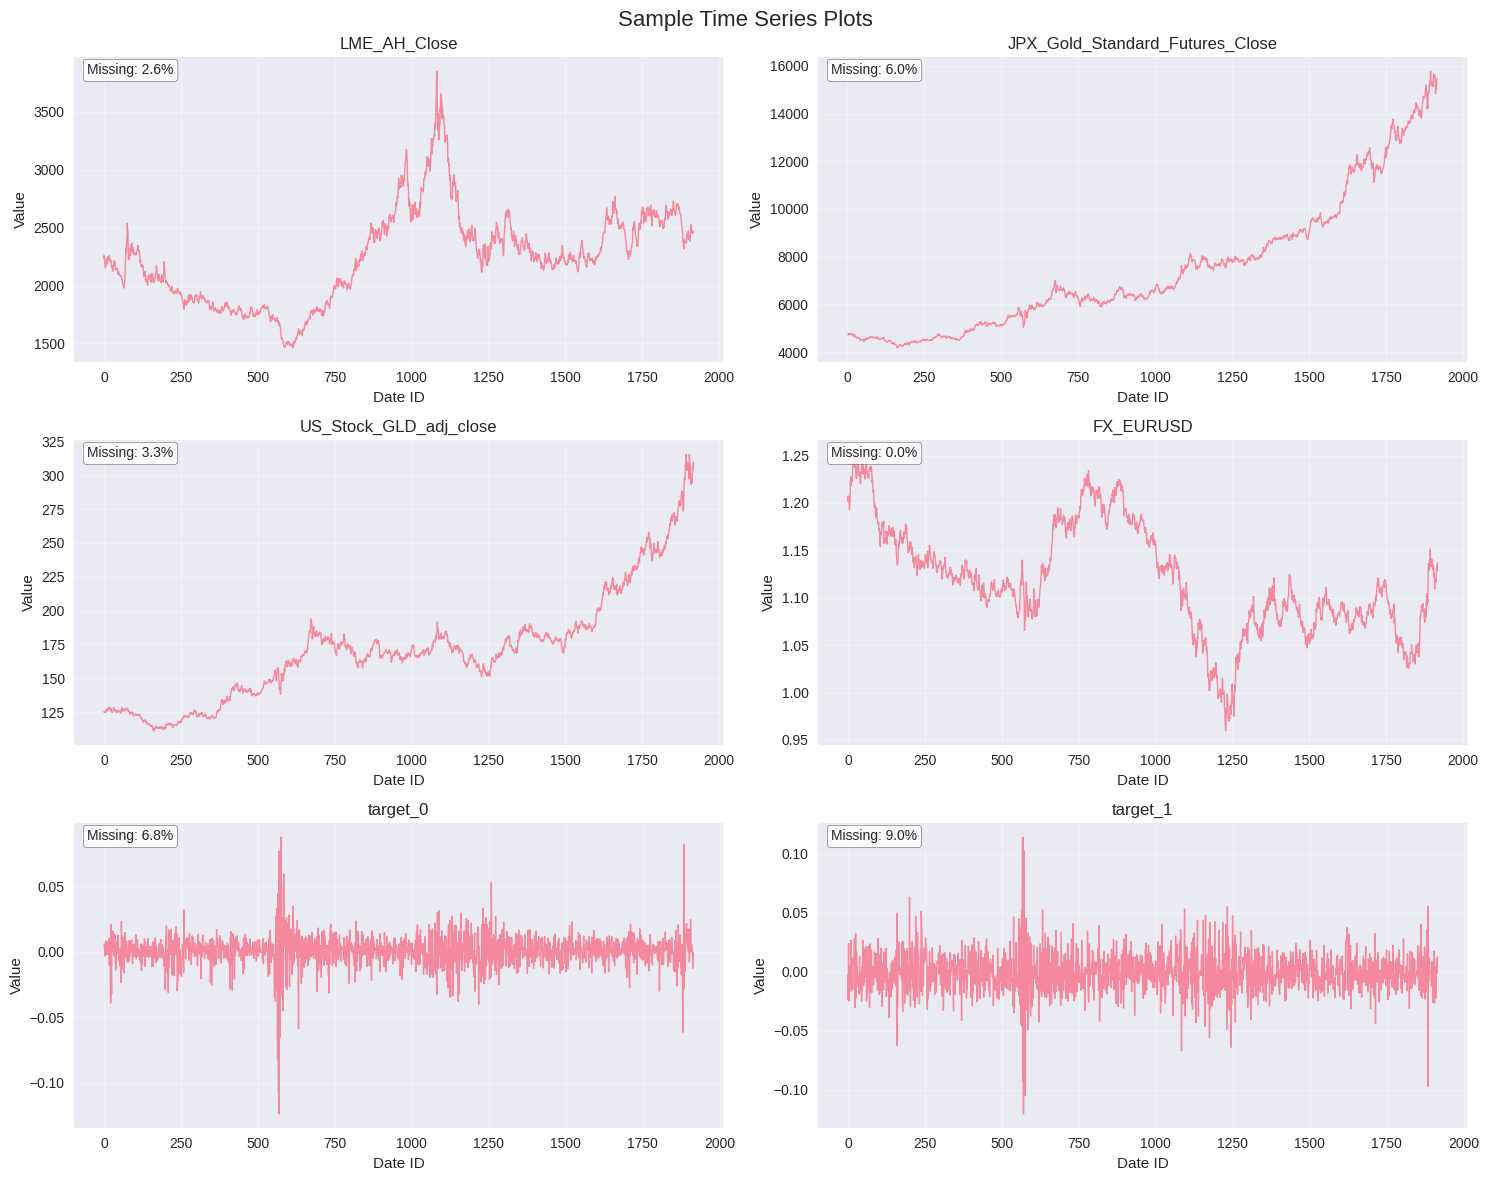

In [ ]:
# Analyze time series patterns
print("Time Series Analysis:")
print("-" * 30)

# Basic time info
print(f"Date range: {train['date_id'].min()} to {train['date_id'].max()}")
print(f"Total time periods: {len(train)}")

# Check for gaps in time series
date_gaps = np.diff(train['date_id'].sort_values())
print(f"Date gaps: min={date_gaps.min()}, max={date_gaps.max()}, unique={np.unique(date_gaps)}")

# Plot some time series
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Sample different categories of features
sample_features = [
    'LME_AH_Close',  # Metal
    'JPX_Gold_Standard_Futures_Close',  # Futures
    'US_Stock_GLD_adj_close',  # US Stock (Gold ETF)
    'FX_EURUSD',  # FX
    'target_0',  # Target
    'target_1'   # Target
]

for idx, feature in enumerate(sample_features):
    ax = axes[idx // 2, idx % 2]

    if feature.startswith('target_'):
        data = train_labels
    else:
        data = train

    # Plot non-null values
    mask = data[feature].notna()
    x_vals = data.loc[mask, 'date_id']
    y_vals = data.loc[mask, feature]

    ax.plot(x_vals, y_vals, linewidth=1, alpha=0.8)
    ax.set_title(f'{feature}')
    ax.set_xlabel('Date ID')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

    # Add missing data info
    missing_pct = (data[feature].isnull().sum() / len(data) * 100)
    ax.text(0.02, 0.98, f'Missing: {missing_pct:.1f}%',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle('Sample Time Series Plots', fontsize=16)
plt.tight_layout()
plt.show()

# correlation analysis

correlation analysis


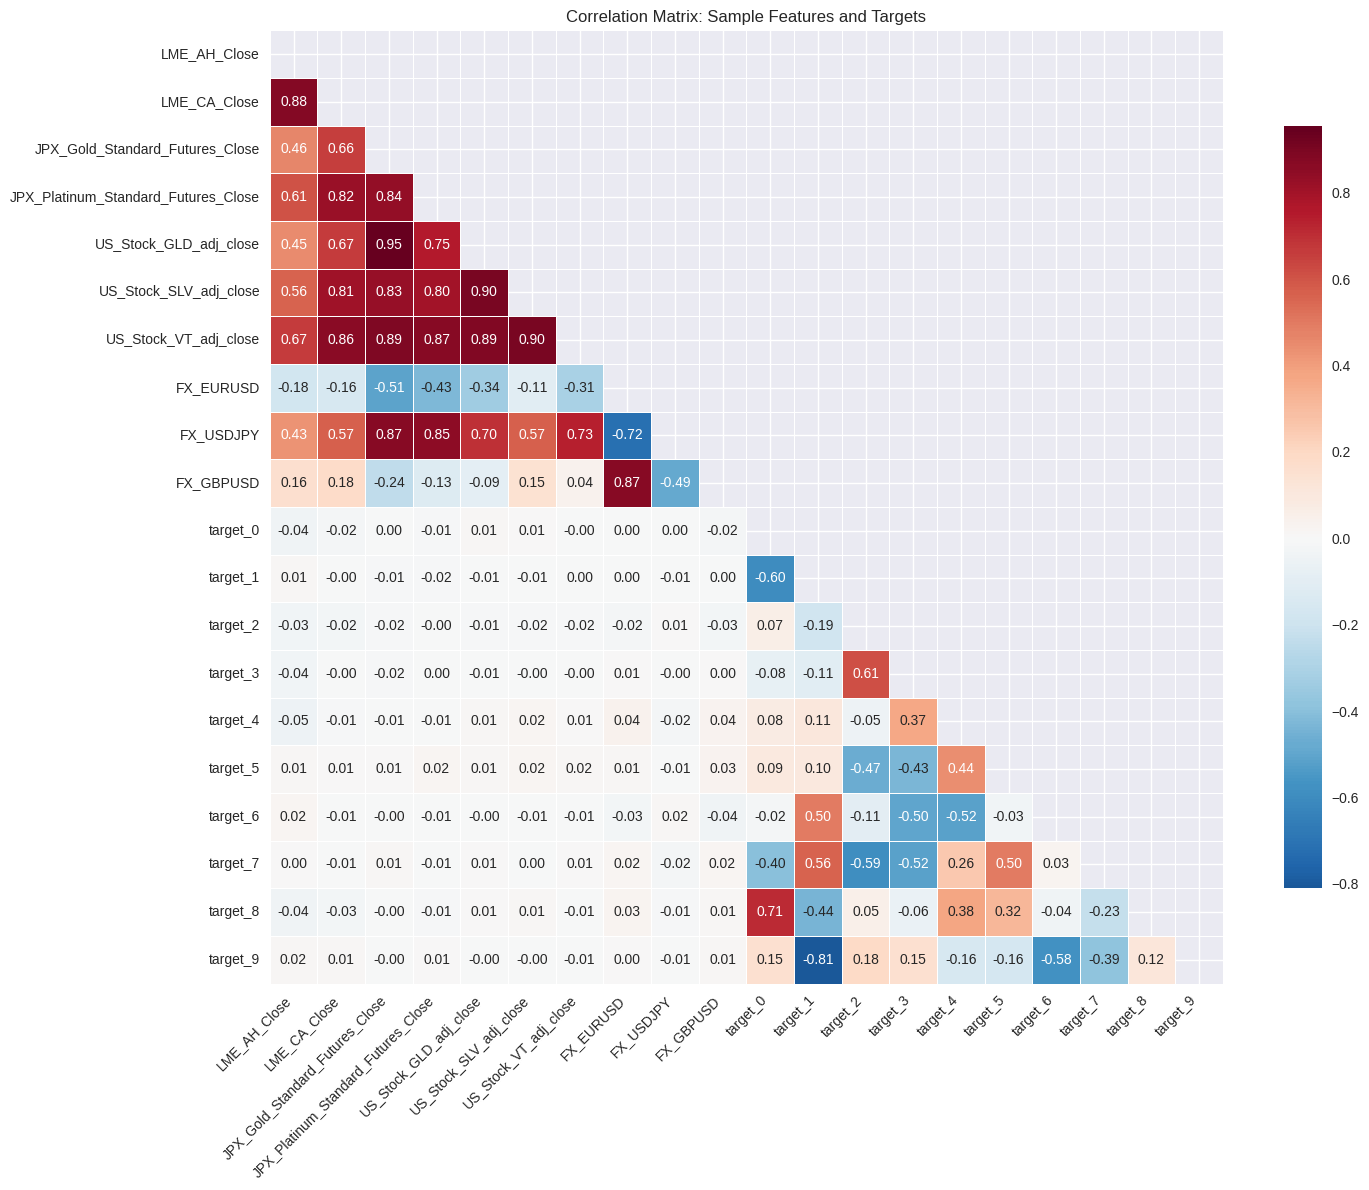


Highest Feature-Target Correlations:
Top 10 Feature-Target Correlations:
  LME_AH_Close <-> target_4: -0.052
  FX_EURUSD <-> target_4: 0.043
  LME_AH_Close <-> target_8: -0.043
  LME_AH_Close <-> target_0: -0.040
  FX_GBPUSD <-> target_6: -0.038
  FX_GBPUSD <-> target_4: 0.038
  LME_AH_Close <-> target_3: -0.036
  FX_GBPUSD <-> target_5: 0.032
  LME_AH_Close <-> target_2: -0.032
  FX_EURUSD <-> target_6: -0.029


In [ ]:
print('correlation analysis')

sample_features_dict = {
    'LME': ['LME_AH_Close', 'LME_CA_Close'],
    'JPX': ['JPX_Gold_Standard_Futures_Close', 'JPX_Platinum_Standard_Futures_Close'],
    'US_Stock': ['US_Stock_GLD_adj_close', 'US_Stock_SLV_adj_close', 'US_Stock_VT_adj_close'],
    'FX': ['FX_EURUSD', 'FX_USDJPY', 'FX_GBPUSD']
}

sample_features = []
for features in sample_features_dict.values():
    sample_features.extend(features)

# Add some targets
sample_targets = target_columns[:10]

# Create combined dataset for correlation using merge instead of concat
correlation_data = pd.merge(
    train[['date_id'] + sample_features],
    train_labels[['date_id'] + sample_targets],
    on='date_id',
    how='inner'
)

# Calculate correlation matrix
corr_matrix = correlation_data[sample_features + sample_targets].corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Correlation Matrix: Sample Features and Targets')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find highest correlations with targets
print("\nHighest Feature-Target Correlations:")
feature_target_corr = []
for target in sample_targets:
    for feature in sample_features:
        corr_val = corr_matrix.loc[feature, target]
        if not pd.isna(corr_val):
            feature_target_corr.append((feature, target, abs(corr_val), corr_val))

# Sort by absolute correlation
feature_target_corr.sort(key=lambda x: x[2], reverse=True)

print("Top 10 Feature-Target Correlations:")
for feature, target, abs_corr, corr in feature_target_corr[:10]:
    print(f"  {feature} <-> {target}: {corr:.3f}")

# feature engineering insights

In [ ]:
print('feature engineering analysis')

sample_price_series = ['LME_AH_Close', 'US_Stock_GLD_adj_close', 'FX_EURUSD']
for feature in sample_price_series:
    data = train[feature].dropna()
    if len(data) > 1:
        # Calculate rolling statistics
        rolling_std = data.rolling(window=5, min_periods=1).std()
        rolling_mean = data.rolling(window=5, min_periods=1).mean()

        print(f"\n{feature}:")
        print(f"  Price range: {data.min():.4f} - {data.max():.4f}")
        print(f"  Average 5-day volatility: {rolling_std.mean():.4f}")
        print(f"  Volatility range: {rolling_std.min():.4f} - {rolling_std.max():.4f}")

# 2. Cross-category relationships
print(f"\nCross-Category Analysis:")
print(f"Available feature categories for relationships:")
for category, features in feature_categories.items():
    if features and category != 'Other':
        print(f"  {category}: {len(features)} features")

# 3. Target pair analysis
print(f"\nTarget Pair Insights:")
pair_instruments = set()
for _, row in target_pairs.iterrows():
    pair = row['pair']
    if ' - ' in pair:
        instruments = pair.split(' - ')
        pair_instruments.update(instruments)
    else:
        pair_instruments.add(pair)

print(f"  Unique instruments in targets: {len(pair_instruments)}")
print(f"  Sample instruments: {list(pair_instruments)[:10]}")

feature engineering analysis

LME_AH_Close:
  Price range: 1462.0000 - 3849.0000
  Average 5-day volatility: 26.9350
  Volatility range: 2.7973 - 214.8640

US_Stock_GLD_adj_close:
  Price range: 111.1000 - 315.5900
  Average 5-day volatility: 1.3988
  Volatility range: 0.0704 - 10.5454

FX_EURUSD:
  Price range: 0.9596 - 1.2514
  Average 5-day volatility: 0.0045
  Volatility range: 0.0004 - 0.0203

Cross-Category Analysis:
Available feature categories for relationships:
  LME: 4 features
  JPX: 40 features
  US: 475 features
  FX: 38 features

Target Pair Insights:
  Unique instruments in targets: 106
  Sample instruments: ['FX_GBPUSD', 'FX_NZDCHF', 'FX_CHFJPY', 'FX_ZARUSD', 'US_Stock_ALB_adj_close', 'US_Stock_HAL_adj_close', 'US_Stock_DE_adj_close', 'US_Stock_IEF_adj_close', 'JPX_Platinum_Standard_Futures_Close', 'US_Stock_EEM_adj_close']


# data quality assessment

Data Quality Assessment:
------------------------------

Training Data:
  Shape: (1917, 558)
  Memory usage: 8.16 MB
  Missing values: 43,230 / 1,069,686 (4.04%)
  Data types: {dtype('float64'): np.int64(557), dtype('int64'): np.int64(1)}
  Duplicate date_ids: 0

Training Labels:
  Shape: (1917, 425)
  Memory usage: 6.22 MB
  Missing values: 85,899 / 814,725 (10.54%)
  Data types: {dtype('float64'): np.int64(424), dtype('int64'): np.int64(1)}
  Duplicate date_ids: 0

Target Pairs:
  Shape: (424, 3)
  Memory usage: 0.07 MB
  Missing values: 0 / 1,272 (0.00%)
  Data types: {dtype('O'): np.int64(2), dtype('int64'): np.int64(1)}


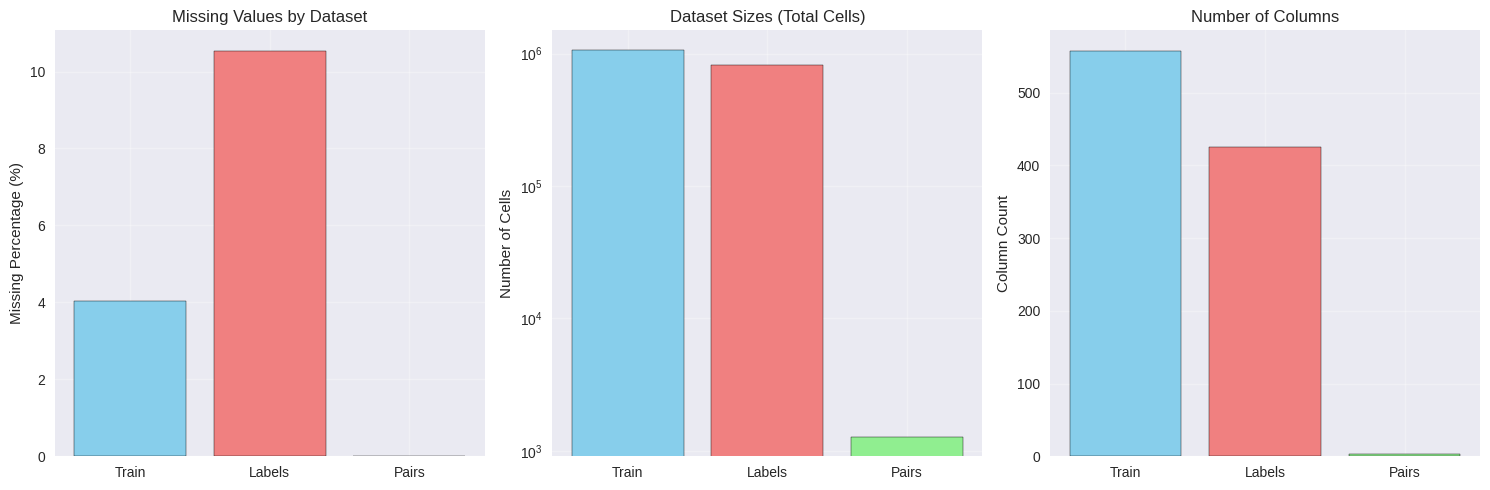

In [ ]:
# Comprehensive data quality assessment
print("Data Quality Assessment:")
print("-" * 30)

def assess_data_quality(df, df_name):
    print(f"\n{df_name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Missing values
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isnull().sum().sum()
    missing_pct = (missing_cells / total_cells) * 100
    print(f"  Missing values: {missing_cells:,} / {total_cells:,} ({missing_pct:.2f}%)")

    # Data types
    print(f"  Data types: {dict(df.dtypes.value_counts())}")

    # Duplicates
    if 'date_id' in df.columns:
        dup_dates = df['date_id'].duplicated().sum()
        print(f"  Duplicate date_ids: {dup_dates}")

    return {
        'missing_pct': missing_pct,
        'missing_cells': missing_cells,
        'shape': df.shape
    }

# Assess all datasets
train_quality = assess_data_quality(train, "Training Data")
labels_quality = assess_data_quality(train_labels, "Training Labels")
pairs_quality = assess_data_quality(target_pairs, "Target Pairs")

# Summary visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Missing values comparison
datasets = ['Train', 'Labels', 'Pairs']
missing_pcts = [train_quality['missing_pct'], labels_quality['missing_pct'], pairs_quality['missing_pct']]

axes[0].bar(datasets, missing_pcts, color=['skyblue', 'lightcoral', 'lightgreen'], edgecolor='black')
axes[0].set_title('Missing Values by Dataset')
axes[0].set_ylabel('Missing Percentage (%)')
axes[0].grid(True, alpha=0.3)

# Dataset sizes
sizes = [train_quality['shape'][0] * train_quality['shape'][1],
         labels_quality['shape'][0] * labels_quality['shape'][1],
         pairs_quality['shape'][0] * pairs_quality['shape'][1]]

axes[1].bar(datasets, sizes, color=['skyblue', 'lightcoral', 'lightgreen'], edgecolor='black')
axes[1].set_title('Dataset Sizes (Total Cells)')
axes[1].set_ylabel('Number of Cells')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

# Column counts
cols = [train_quality['shape'][1], labels_quality['shape'][1], pairs_quality['shape'][1]]
axes[2].bar(datasets, cols, color=['skyblue', 'lightcoral', 'lightgreen'], edgecolor='black')
axes[2].set_title('Number of Columns')
axes[2].set_ylabel('Column Count')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# advaced feature engineering

In [ ]:
# Comprehensive feature engineering for financial time series
print("Advanced Feature Engineering:")
print("-" * 35)

def create_technical_features(df, price_cols, window_sizes=[5, 10, 20]):
    """Create technical indicators for price series"""
    features = df.copy()

    for col in price_cols:
        if col in df.columns:
            # Moving averages
            for window in window_sizes:
                features[f'{col}_MA_{window}'] = df[col].rolling(window=window).mean()
                features[f'{col}_STD_{window}'] = df[col].rolling(window=window).std()

            # Price changes and returns
            features[f'{col}_Return_1d'] = df[col].pct_change(1)
            features[f'{col}_Return_5d'] = df[col].pct_change(5)
            features[f'{col}_LogReturn_1d'] = np.log(df[col] / df[col].shift(1))

            # Bollinger Bands
            ma_20 = df[col].rolling(window=20).mean()
            std_20 = df[col].rolling(window=20).std()
            features[f'{col}_BB_Upper'] = ma_20 + (2 * std_20)
            features[f'{col}_BB_Lower'] = ma_20 - (2 * std_20)
            features[f'{col}_BB_Position'] = (df[col] - features[f'{col}_BB_Lower']) / (features[f'{col}_BB_Upper'] - features[f'{col}_BB_Lower'])

            # RSI
            delta = df[col].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / loss
            features[f'{col}_RSI'] = 100 - (100 / (1 + rs))

    return features

def create_cross_asset_features(df, asset_groups):
    """Create cross-asset relationship features"""
    features = df.copy()

    # Asset class correlations
    for group_name, assets in asset_groups.items():
        available_assets = [asset for asset in assets if asset in df.columns]
        if len(available_assets) >= 2:
            # Rolling correlations between assets
            for i, asset1 in enumerate(available_assets):
                for asset2 in available_assets[i+1:]:
                    corr_5d = df[asset1].rolling(5).corr(df[asset2])
                    corr_20d = df[asset1].rolling(20).corr(df[asset2])
                    features[f'{group_name}_Corr_5d_{asset1}_{asset2}'] = corr_5d
                    features[f'{group_name}_Corr_20d_{asset1}_{asset2}'] = corr_20d

            # Asset class momentum
            group_returns = df[available_assets].pct_change()
            features[f'{group_name}_Momentum_5d'] = group_returns.rolling(5).mean().mean(axis=1)
            features[f'{group_name}_Volatility_5d'] = group_returns.rolling(5).std().mean(axis=1)

    return features

# Example implementation
sample_price_cols = ['LME_AH_Close', 'LME_CA_Close', 'US_Stock_GLD_adj_close', 'FX_EURUSD']
asset_groups = {
    'Metals': ['LME_AH_Close', 'LME_CA_Close'],
    'Gold': ['JPX_Gold_Standard_Futures_Close', 'US_Stock_GLD_adj_close'],
    'Major_FX': ['FX_EURUSD', 'FX_USDJPY', 'FX_GBPUSD']
}

print("Technical Features Example:")
print("Sample features that would be created:")
for col in sample_price_cols[:2]:
    print(f"\n{col}:")
    print(f"  - Moving averages (5, 10, 20 day)")
    print(f"  - Volatility measures")
    print(f"  - Returns (1d, 5d)")
    print(f"  - Bollinger Bands position")
    print(f"  - RSI indicator")

print(f"\nCross-asset features:")
for group, assets in asset_groups.items():
    print(f"  {group}: Rolling correlations, group momentum, group volatility")

Advanced Feature Engineering:
-----------------------------------
Technical Features Example:
Sample features that would be created:

LME_AH_Close:
  - Moving averages (5, 10, 20 day)
  - Volatility measures
  - Returns (1d, 5d)
  - Bollinger Bands position
  - RSI indicator

LME_CA_Close:
  - Moving averages (5, 10, 20 day)
  - Volatility measures
  - Returns (1d, 5d)
  - Bollinger Bands position
  - RSI indicator

Cross-asset features:
  Metals: Rolling correlations, group momentum, group volatility
  Gold: Rolling correlations, group momentum, group volatility
  Major_FX: Rolling correlations, group momentum, group volatility


#model architecture strategies


In [ ]:
# 1. Multi-Target Neural Network Architecture
def design_multui_target_models():
  """
  Multi-target model with shared and specialized model
  """
  architecture = {
      'shared_layers':{
          'dense_1': 256,
          'dropout_1': 0.3,
          'dense_2': 128,
          'dropout_2': 0.2
      },
      'asset_specific_layers':{
          'lme_head': {'dense': 64, 'output': 'lme_targets'},
          'jpx_head': {'dense': 32, 'output': 'jpx_targets'},
          'us_stock_head': {'dense': 64, 'output': 'us_stock_targets'},
          'fx_head': {'dense': 32, 'output': 'fx_targets'}
      },
      'final_layer': {
          'output_newrons': 424, #number of targets
          'activation': 'linear'
      }
  }
  return architecture

#2, time series model
def lstm_architecture():
  """
  LSTM model for temporal dependencies
  """
  config = {
      'sequence_length': 30,
      'lstm_layers':[
          {'units': 128, 'return_sequences': True, 'dropout': 0.2},
          {'units': 64, 'return_sequences': False, 'dropout': 0.2}
      ],
      'dense_layers':[
          {'units': 128, 'activation': 'relu', 'dropout': 0.3},
          {'units': 64, 'activation': 'relu', 'dropout': 0.2}
      ],
      'output_layer': [
          {'units': 424}, #number of targets,
          {'activation': 'linear'}
      ]
  }
  return config

#3, transformer architecture
def transformer_config():
  """
  Transfomer model for financial time series
  """
  config = {
      'seqence_length': 30,
      'embedding_dim': 128,
      'num_heads': 8,
      'num_transfomer_blocks': 4,
      'ff_dim': 256,
      'dropout_rate': 0.1,
      'attention_dropout': 0.1
  }
  return config

# Print architectures
print("1. Multi-Target Neural Network:")
arch = design_multui_target_models()
for component, details in arch.items():
    print(f"   {component}: {details}")

print(f"\n2. LSTM Architecture:")
lstm_config = lstm_architecture()
for component, details in lstm_config.items():
    print(f"   {component}: {details}")

print(f"\n3. Transformer Configuration:")
trans_config = transformer_config()
for param, value in trans_config.items():
    print(f"   {param}: {value}")

1. Multi-Target Neural Network:
   shared_layers: {'dense_1': 256, 'dropout_1': 0.3, 'dense_2': 128, 'dropout_2': 0.2}
   asset_specific_layers: {'lme_head': {'dense': 64, 'output': 'lme_targets'}, 'jpx_head': {'dense': 32, 'output': 'jpx_targets'}, 'us_stock_head': {'dense': 64, 'output': 'us_stock_targets'}, 'fx_head': {'dense': 32, 'output': 'fx_targets'}}
   final_layer: {'output_newrons': 424, 'activation': 'linear'}

2. LSTM Architecture:
   sequence_length: 30
   lstm_layers: [{'units': 128, 'return_sequences': True, 'dropout': 0.2}, {'units': 64, 'return_sequences': False, 'dropout': 0.2}]
   dense_layers: [{'units': 128, 'activation': 'relu', 'dropout': 0.3}, {'units': 64, 'activation': 'relu', 'dropout': 0.2}]
   output_layer: [{'units': 424}, {'activation': 'linear'}]

3. Transformer Configuration:
   seqence_length: 30
   embedding_dim: 128
   num_heads: 8
   num_transfomer_blocks: 4
   ff_dim: 256
   dropout_rate: 0.1
   attention_dropout: 0.1


# trainng strategy and implementation

In [ ]:
print('Training strategy:')

# Training strategies for financial time series
print("Training Strategy Recommendations:")
print("-" * 40)

def get_training_strategy():
    strategy = {
        'data_splitting': {
            'method': 'time_based',
            'train_ratio': 0.7,
            'validation_ratio': 0.15,
            'test_ratio': 0.15,
            'gap_days': 5  # Gap between train/val to prevent leakage
        },
        'preprocessing': {
            'scaling': 'RobustScaler',  # Less sensitive to outliers
            'missing_values': 'forward_fill_then_interpolate',
            'outlier_handling': 'winsorize_99_percentile'
        },
        'loss_functions': {
            'primary': 'mse',
            'alternatives': ['huber_loss', 'quantile_loss'],
            'weights': 'inverse_variance'  # Weight targets by inverse variance
        },
        'optimization': {
            'optimizer': 'AdamW',
            'learning_rate': 0.001,
            'weight_decay': 0.01,
            'scheduler': 'CosineAnnealingWarmRestarts'
        },
        'regularization': {
            'dropout': [0.1, 0.2, 0.3],  # Different rates for different layers
            'batch_normalization': True,
            'early_stopping': {'patience': 20, 'min_delta': 1e-6}
        }
    }
    return strategy

def cross_validation_strategy():
    cv_strategy = {
        'method': 'TimeSeriesSplit',
        'n_splits': 5,
        'gap': 5,  # Days between train and test
        'test_size': 90,  # Days in test set
        'expanding_window': True  # Use all previous data for training
    }
    return cv_strategy

strategy = get_training_strategy()
cv_strategy = cross_validation_strategy()

print("Training Strategy Details:")
for component, details in strategy.items():
    print(f"\n{component.upper()}:")
    if isinstance(details, dict):
        for key, value in details.items():
            print(f"  {key}: {value}")
    else:
        print(f"  {details}")

print(f"\nCross-Validation Strategy:")
for key, value in cv_strategy.items():
    print(f"  {key}: {value}")


Training strategy:
Training Strategy Recommendations:
----------------------------------------
Training Strategy Details:

DATA_SPLITTING:
  method: time_based
  train_ratio: 0.7
  validation_ratio: 0.15
  test_ratio: 0.15
  gap_days: 5

PREPROCESSING:
  scaling: RobustScaler
  missing_values: forward_fill_then_interpolate
  outlier_handling: winsorize_99_percentile

LOSS_FUNCTIONS:
  primary: mse
  alternatives: ['huber_loss', 'quantile_loss']
  weights: inverse_variance

OPTIMIZATION:
  optimizer: AdamW
  learning_rate: 0.001
  weight_decay: 0.01
  scheduler: CosineAnnealingWarmRestarts

REGULARIZATION:
  dropout: [0.1, 0.2, 0.3]
  batch_normalization: True
  early_stopping: {'patience': 20, 'min_delta': 1e-06}

Cross-Validation Strategy:
  method: TimeSeriesSplit
  n_splits: 5
  gap: 5
  test_size: 90
  expanding_window: True


#ensemble methds and model selection

In [ ]:
def ensemble_strategies():
    strategies = {
        'level_1_models': {
            'LSTM': {
                'specialization': 'temporal_patterns',
                'weight': 0.3,
                'lookback': 30
            },
            'XGBoost': {
                'specialization': 'feature_interactions',
                'weight': 0.25,
                'max_depth': 6
            },
            'LightGBM': {
                'specialization': 'fast_training',
                'weight': 0.25,
                'num_leaves': 31
            },
            'Transformer': {
                'specialization': 'long_dependencies',
                'weight': 0.2,
                'attention_heads': 8
            }
        },
        'level_2_meta_learner': {
            'model': 'Ridge_Regression',
            'features': ['model_predictions', 'model_confidence', 'market_regime'],
            'cv_method': 'time_series_split'
        },
        'target_specific_models': {
            'single_asset_targets': 'LSTM + Technical_Features',
            'pair_targets': 'XGBoost + Cross_Asset_Features',
            'fx_targets': 'Transformer + Economic_Indicators'
        }
    }
    return strategies

def model_selection_criteria():
    criteria = {
        'primary_metrics': {
            'RMSE': 'Root Mean Square Error',
            'MAE': 'Mean Absolute Error',
            'Correlation': 'Prediction-Target Correlation'
        },
        'stability_metrics': {
            'Sharpe_Ratio': 'Risk-adjusted returns',
            'Max_Drawdown': 'Worst-case losses',
            'Hit_Rate': 'Directional accuracy'
        },
        'robustness_tests': {
            'Market_Stress': 'Performance during volatility spikes',
            'Regime_Changes': 'Adaptation to different market conditions',
            'Out_of_Sample': 'Performance on completely unseen data'
        }
    }
    return criteria

ensemble_info = ensemble_strategies()
selection_criteria = model_selection_criteria()

print("Ensemble Architecture:")
for level, models in ensemble_info.items():
    print(f"\n{level.upper()}:")
    if isinstance(models, dict):
        for model, config in models.items():
            print(f"  {model}: {config}")

print(f"\nModel Selection Criteria:")
for category, metrics in selection_criteria.items():
    print(f"\n{category.upper()}:")
    for metric, description in metrics.items():
        print(f"  {metric}: {description}")

Ensemble Architecture:

LEVEL_1_MODELS:
  LSTM: {'specialization': 'temporal_patterns', 'weight': 0.3, 'lookback': 30}
  XGBoost: {'specialization': 'feature_interactions', 'weight': 0.25, 'max_depth': 6}
  LightGBM: {'specialization': 'fast_training', 'weight': 0.25, 'num_leaves': 31}
  Transformer: {'specialization': 'long_dependencies', 'weight': 0.2, 'attention_heads': 8}

LEVEL_2_META_LEARNER:
  model: Ridge_Regression
  features: ['model_predictions', 'model_confidence', 'market_regime']
  cv_method: time_series_split

TARGET_SPECIFIC_MODELS:
  single_asset_targets: LSTM + Technical_Features
  pair_targets: XGBoost + Cross_Asset_Features
  fx_targets: Transformer + Economic_Indicators

Model Selection Criteria:

PRIMARY_METRICS:
  RMSE: Root Mean Square Error
  MAE: Mean Absolute Error
  Correlation: Prediction-Target Correlation

STABILITY_METRICS:
  Sharpe_Ratio: Risk-adjusted returns
  Max_Drawdown: Worst-case losses
  Hit_Rate: Directional accuracy

ROBUSTNESS_TESTS:
  Market

#evaluation metrics and backtesting

In [ ]:
# Comprehensive evaluation framework
print("Evaluation Framework:")
print("-" * 25)

def evaluation_metrics():
    metrics = {
        'regression_metrics': {
            'RMSE': 'sqrt(mean((y_true - y_pred)^2))',
            'MAE': 'mean(abs(y_true - y_pred))',
            'MAPE': 'mean(abs((y_true - y_pred) / y_true)) * 100',
            'R2_Score': 'coefficient of determination'
        },
        'financial_metrics': {
            'Information_Ratio': 'excess_return / tracking_error',
            'Sharpe_Ratio': '(return - risk_free_rate) / volatility',
            'Calmar_Ratio': 'annual_return / max_drawdown',
            'Hit_Rate': 'percentage of correct direction predictions'
        },
        'risk_metrics': {
            'VaR_95': '95th percentile of losses',
            'CVaR_95': 'Expected loss beyond VaR',
            'Max_Drawdown': 'maximum peak-to-trough decline',
            'Volatility': 'standard deviation of returns'
        },
        'stability_metrics': {
            'Prediction_Stability': 'consistency across time periods',
            'Feature_Importance_Stability': 'consistency of feature rankings',
            'Cross_Validation_Std': 'stability across CV folds'
        }
    }
    return metrics

def backtesting_framework():
    framework = {
        'walk_forward_analysis': {
            'window_size': 252,  # 1 year of trading days
            'step_size': 21,     # 1 month steps
            'retraining_frequency': 'monthly',
            'lookback_period': 756  # 3 years
        },
        'stress_testing': {
            'market_crashes': ['2008_crisis', '2020_covid', 'custom_scenarios'],
            'volatility_regimes': ['low_vol', 'medium_vol', 'high_vol'],
            'correlation_breakdowns': 'periods of unusual correlations'
        },
        'scenario_analysis': {
            'bull_markets': 'strong trending periods',
            'bear_markets': 'declining market periods',
            'sideways_markets': 'range-bound periods',
            'crisis_periods': 'extreme volatility events'
        }
    }
    return framework

metrics_info = evaluation_metrics()
backtest_info = backtesting_framework()

print("Evaluation Metrics by Category:")
for category, metrics in metrics_info.items():
    print(f"\n{category.upper()}:")
    for metric, description in metrics.items():
        print(f"  {metric}: {description}")

print(f"\nBacktesting Framework:")
for component, details in backtest_info.items():
    print(f"\n{component.upper()}:")
    if isinstance(details, dict):
        for key, value in details.items():
            print(f"  {key}: {value}")
    else:
        print(f"  {details}")

Evaluation Framework:
-------------------------
Evaluation Metrics by Category:

REGRESSION_METRICS:
  RMSE: sqrt(mean((y_true - y_pred)^2))
  MAE: mean(abs(y_true - y_pred))
  MAPE: mean(abs((y_true - y_pred) / y_true)) * 100
  R2_Score: coefficient of determination

FINANCIAL_METRICS:
  Information_Ratio: excess_return / tracking_error
  Sharpe_Ratio: (return - risk_free_rate) / volatility
  Calmar_Ratio: annual_return / max_drawdown
  Hit_Rate: percentage of correct direction predictions

RISK_METRICS:
  VaR_95: 95th percentile of losses
  CVaR_95: Expected loss beyond VaR
  Max_Drawdown: maximum peak-to-trough decline
  Volatility: standard deviation of returns

STABILITY_METRICS:
  Prediction_Stability: consistency across time periods
  Feature_Importance_Stability: consistency of feature rankings
  Cross_Validation_Std: stability across CV folds

Backtesting Framework:

WALK_FORWARD_ANALYSIS:
  window_size: 252
  step_size: 21
  retraining_frequency: monthly
  lookback_period: 75